#### Libraries

In [2]:
import pickle as pkl
import networkx as nx
import numpy as np
from tqdm import tqdm
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

with open("Data/training_data.pkl", 'rb') as file:
    train_graphs = pkl.load(file)


#### Direct Product Kernel

In [2]:
def direct_product(G1, G2, node_label, edge_label):
    from itertools import product
    GP = nx.Graph()
    # add nodes
    for u, v in product(G1, G2):
        if G1.nodes[u][node_label] == G2.nodes[v][node_label]:
            GP.add_node((u, v))
            GP.nodes[(u, v)].update({node_label: G1.nodes[u][node_label]})

    # add edges
    for u, v in product(GP, GP):
            if (u[0], v[0]) in G1.edges and (u[1], v[1]) in G2.edges and G1.edges[u[0],v[0]][edge_label] == G2.edges[u[1],v[1]][edge_label]:
                GP.add_edge((u[0], u[1]), (v[0], v[1]))
                GP.edges[(u[0], u[1]), (v[0], v[1])].update({edge_label:G1.edges[u[0], v[0]][edge_label]})

    return GP

Example from class slides (p.462) to check implementation

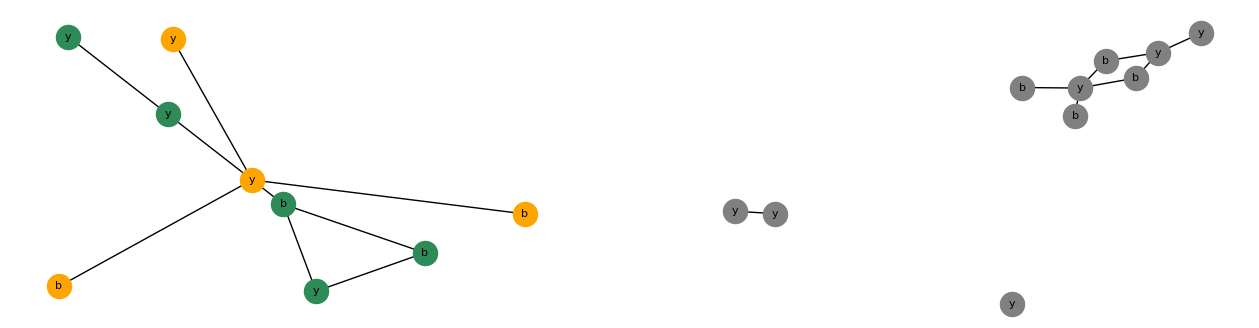

In [3]:
import networkx as nx
from lib import draw
G1 = nx.Graph()
G1.add_nodes_from([1,2,3,4])
G1.add_edges_from([(1,2), (2,3), (2,4)])
nx.set_node_attributes(G1, {1: 'y', 2: 'y', 3: 'b', 4: 'b'}, "labels")
nx.set_edge_attributes(G1, {e: '-' for e in G1.edges()}, "labels")

G2 = nx.Graph()
G2.add_nodes_from([chr(i) for i in range(65, 70)])
E = [(65, 66), (66, 67), (67, 68), (67, 69), (68, 69)]
G2.add_edges_from([tuple(chr(i) for i in e) for e in E])
nx.set_node_attributes(G2, {chr(i): 'y' for i in [65, 66, 68]} | {chr(i) : 'b' for i in [67, 69]}, "labels")
nx.set_edge_attributes(G2, {e: '-' for e in G2.edges()}, "labels")

import matplotlib.pyplot as plt
plt.figure(figsize=(16, 4))
plt.subplot(1,2,1)
draw(G1, 'orange')
draw(G2, 'seagreen')

plt.subplot(1,2,2)
from lib import direct_product
J = direct_product(G1, G2)
draw(J, 'gray')


In [4]:
import scipy.sparse as ss
def DPKernel(Gx):
    adjacencymatrix = nx.adjacency_matrix(Gx)
    rho = ss.linalg.norm(adjacencymatrix)
    infsum = ss.linalg.inv( ss.eye(adjacencymatrix.shape[0], format='csc') - rho*adjacencymatrix )
    k = np.sum(np.abs(infsum))
    return k

In [5]:
DPKernel(direct_product(train_graphs[0], train_graphs[1]))

184.3809476646171

#### Generate Data

DP Kernel and nth-order kernel

In [6]:
from lib import direct_product , DPKernel, kernel_nthorder

N = len(train_graphs)
K_dp = np.zeros((N,N))
K_nth = np.zeros((N,N))

for i in tqdm(range(N)):
    G1 = train_graphs[i]
    for j in range(i+1): #K will be symmetric, so only calculate upper and then change
        G2 = train_graphs[j]        
        Gx = direct_product(G1, G2)
        
        K_dp[i,j] = DPKernel(Gx)
        K_nth[i,j] = kernel_nthorder(Gx, n=10)

#extract diagonal and then make into diagonal matrix
K_dp = K_dp + K_dp.T - np.diag(np.diag(K_dp)) 
K_nth = K_nth + K_nth.T - np.diag(np.diag(K_nth))

  0%|          | 4/6000 [00:02<55:20,  1.81it/s]


KeyboardInterrupt: 

In [ ]:
np.savetxt('Data/DPKernel.txt', K_dp)
np.savetxt('Data/nthOKernel.txt', K_nth)

#### Hadamard + RW

In [7]:
hmax = 5

prob1 = np.repeat(.5,2)
prob2 = np.repeat(.5,2)
c = 0.1

In [1]:
from lib import hadamard_kernel, kernel_randomwalk
N = len(train_graphs)
Kh = np.zeros((N,N))
Krw = np.zeros((N,N))
for i in tqdm(range(N)):
    G1 = train_graphs[i]
    for j in range(i+1): #K will be symmetric, so only calculate upper and then change
        G2 = train_graphs[j]        
        # Kh[i,j] = hadamard_kernel(G1, G2, hmax=hmax)
        Krw[i,j] = kernel_randomwalk(G1, G2, prob1, prob2, c)

# Kh = Kh + Kh.T - np.diag(np.diag(Kh)) #extract diagonal and then make into diagonal matrix
Krw = Krw + Krw.T - np.diag(np.diag(Krw))

# np.savetxt('Data/HadKernel.txt', Kh)
np.savetxt('Data/RWKernel.txt', Krw)

NameError: name 'train_graphs' is not defined